In [45]:
#Loan-Default-Prediction-and-Evaluation-Criteria.git

In [46]:
import pandas as pd
import numpy as np

In [47]:
df = pd.read_csv("D:\Data Science case study\-Loan-Default-Prediction-and-Evaluation-Criteria\RAW_DATA\DATA\data-selected\Data_Dictionary.csv")

In [48]:
df1=pd.read_csv("D:\Data Science case study\-Loan-Default-Prediction-and-Evaluation-Criteria\RAW_DATA\DATA\data-selected\Dataset.csv")

In [49]:
df.head()

,Variable,Description
0,ID,Client Loan application ID
1,Client_Income,Client Income in $
2,Car_Owned,Any Car owned by client before applying for th...
3,Bike_Owned,Any bike owned by client (0 means No and 1 mea...
4,Active_Loan,Any other active loan at the time of aplicatio...


In [50]:
df1.head()

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,...,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
0,12142509,6750,0.0,0.0,1.0,0.0,0.0,61190.55,3416.85,Alone,...,Yes,Yes,Self-employed,0.568066,0.478787,NaN,0.0186,63.0,NaN,0
1,12138936,20250,1.0,0.0,1.0,NaN,0.0,15282,1826.55,Alone,...,Yes,Yes,Government,0.563360,0.215068,NaN,NaN,NaN,NaN,0
2,12181264,18000,0.0,0.0,1.0,0.0,1.0,59527.35,2788.2,Alone,...,Yes,Yes,Self-employed,NaN,0.552795,0.329655,0.0742,277.0,0.0,0
3,12188929,15750,0.0,0.0,1.0,1.0,0.0,53870.4,2295.45,Alone,...,Yes,Yes,XNA,NaN,0.135182,0.631355,NaN,1700.0,3.0,0
4,12133385,33750,1.0,0.0,1.0,0.0,2.0,133988.4,3547.35,Alone,...,Yes,Yes,Business Entity Type 3,0.508199,0.301182,0.355639,0.2021,674.0,1.0,0


In [51]:
df1.columns

Index(['ID', 'Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan',
       'House_Own', 'Child_Count', 'Credit_Amount', 'Loan_Annuity',
       'Accompany_Client', 'Client_Income_Type', 'Client_Education',
       'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type',
       'Client_Housing_Type', 'Population_Region_Relative', 'Age_Days',
       'Employed_Days', 'Registration_Days', 'ID_Days', 'Own_House_Age',
       'Mobile_Tag', 'Homephone_Tag', 'Workphone_Working', 'Client_Occupation',
       'Client_Family_Members', 'Cleint_City_Rating',
       'Application_Process_Day', 'Application_Process_Hour',
       'Client_Permanent_Match_Tag', 'Client_Contact_Work_Tag',
       'Type_Organization', 'Score_Source_1', 'Score_Source_2',
       'Score_Source_3', 'Social_Circle_Default', 'Phone_Change',
       'Credit_Bureau', 'Default'],
      dtype='object')

In [52]:
df.columns

Index(['Variable', 'Description'], dtype='object')

In [53]:
# # Merge on ID
# df_merged = df.merge(df1, on="ID", how="left")

# print(df_merged.head())
# print(df_merged.shape)


In [ ]:
# EDA Toolkit for Loan Default dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

# -------------------------
# 1) Quick overview
# -------------------------
def quick_overview(df):
    print("Shape:", df.shape)
    display(df.dtypes.value_counts())
    print("\nMemory usage (MB):", df.memory_usage(deep=True).sum() / 1024**2)
    display(df.head().T)

# -------------------------
# 2) Missingness summary
# -------------------------
def missing_summary(df, show_top=20):
    miss = df.isnull().sum().rename("missing_count")
    miss_pct = (miss / len(df)).rename("missing_pct")
    miss_df = pd.concat([miss, miss_pct], axis=1).sort_values("missing_pct", ascending=False)
    display(miss_df.head(show_top))
    # per-row missingness distribution
    row_miss = df.isnull().sum(axis=1)
    print("Rows with at least 1 missing value:", (row_miss>0).sum(), "/", len(df))
    return miss_df

# -------------------------
# 3) Target distribution + imbalance
# -------------------------
def target_summary(df, target_col="Default"):
    vc = df[target_col].value_counts(dropna=False)
    pct = (vc / len(df)).rename("pct")
    print("Target counts:")
    display(pd.concat([vc, pct], axis=1))
    # baseline: fraction default=1
    if 1 in vc.index:
        print("Default rate:", vc.loc[1] / len(df))

# -------------------------
# 4) Numeric feature summary
# -------------------------
def numeric_summary(df, numeric_cols=None):
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    num_desc = df[numeric_cols].describe().T
    num_desc['skew'] = df[numeric_cols].skew()
    num_desc['kurtosis'] = df[numeric_cols].kurtosis()
    display(num_desc.sort_values("skew", ascending=False).head(30))
    return numeric_cols

# -------------------------
# 5) Plot distributions (numerics)
# -------------------------
def plot_numeric_distributions(df, numeric_cols, max_plots=12):
    to_plot = numeric_cols[:max_plots]
    n = len(to_plot)
    cols = 3
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(5*cols, 3*rows))
    for i, c in enumerate(to_plot, 1):
        ax = plt.subplot(rows, cols, i)
        # use hist + KDE-like smoothing via bins
        df[c].dropna().hist(ax=ax, bins=40)
        ax.set_title(f"{c} (n={df[c].notnull().sum()})")
    plt.tight_layout()
    plt.show()

# -------------------------
# 6) Outlier detection (IQR rule)
# -------------------------
def outliers_iqr(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    out = df[(df[col] < lower) | (df[col] > upper)]
    return len(out), lower, upper

def outlier_report(df, numeric_cols, top_n=10):
    reps = []
    for c in numeric_cols:
        if df[c].notnull().sum() < 20:
            continue
        cnt, lo, hi = outliers_iqr(df, c)
        reps.append((c, cnt, lo, hi))
    rep_df = pd.DataFrame(reps, columns=["col", "outlier_count", "lower", "upper"]).sort_values("outlier_count", ascending=False)
    display(rep_df.head(top_n))
    return rep_df

# -------------------------
# 7) Categorical summary
# -------------------------
def categorical_summary(df, cat_cols=None, top_n=10):
    if cat_cols is None:
        cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    out = []
    for c in cat_cols:
        vc = df[c].value_counts(dropna=False)
        out.append((c, df[c].nunique(dropna=True), vc.index[:3].tolist(), int(vc.iloc[0])))
    cat_df = pd.DataFrame(out, columns=["col", "n_unique", "top_3", "top_count"]).sort_values("n_unique", ascending=False)
    display(cat_df.head(top_n))
    return cat_cols

# -------------------------
# 8) Bivariate: default rate by categorical
# -------------------------
def default_rate_by_category(df, cat_col, target="Default", min_count=50):
    grp = df.groupby(cat_col)[target].agg(['count','mean']).sort_values('count', ascending=False)
    grp = grp[grp['count'] >= min_count]
    return grp.rename(columns={'mean': 'default_rate'})

# -------------------------
# 9) Numeric vs target (bucketed)
# -------------------------
def bucket_and_rate(df, col, target="Default", n_bins=10):
    ser = pd.cut(df[col], bins=n_bins)
    grp = df.groupby(ser)[target].agg(['count','mean']).sort_values(by='count', ascending=False)
    return grp.rename(columns={'mean': 'default_rate'})

# -------------------------
# 10) Quick feature importance (simple)
# -------------------------
def quick_feature_importance(df, target="Default", n_features=15):
    # simple preprocessing: label encode categoricals, simple impute numerics
    X = df.drop(columns=[target]).copy()
    y = df[target].copy()
    # drop id-like columns if present
    drop_cols = [c for c in X.columns if c.lower() in ("id", "client_id", "loan_id")]
    X = X.drop(columns=[c for c in drop_cols if c in X.columns], errors='ignore')
    # simple imputer for numeric
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
    if len(num_cols) > 0:
        imp_num = SimpleImputer(strategy='median')
        X[num_cols] = imp_num.fit_transform(X[num_cols])
    # label encode small-cardinality categoricals (careful in production)
    for c in cat_cols:
        X[c] = X[c].astype(str).fillna("NA")
        X[c] = LabelEncoder().fit_transform(X[c])
    # train/test split
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced')
    rf.fit(Xtr, ytr)
    imp = pd.Series(rf.feature_importances_, index=Xtr.columns).sort_values(ascending=False).head(n_features)
    print("AUC on test (quick):", roc_auc_score(yte, rf.predict_proba(Xte)[:,1]))
    display(imp)
    return imp




In [55]:
# -------------------------
# Full run
# -------------------------
def run_eda(df, target="Default"):
    quick_overview(df)
    miss = missing_summary(df, show_top=40)
    target_summary(df, target_col=target)
    numerics = numeric_summary(df)
    plot_numeric_distributions(df, numerics, max_plots=12)
    outlier_report(df, numerics, top_n=12)
    cat_cols = categorical_summary(df, top_n=30)
    # top 5 categorical default rates (for those with enough counts)
    for c in cat_cols[:8]:
        try:
            dr = default_rate_by_category(df, c, target=target, min_count=100)
            if not dr.empty:
                print("\nDefault rate by", c)
                display(dr.head(8))
        except Exception:
            pass
    # top numeric predictors by quick RF
    try:
        quick_feature_importance(df, target=target, n_features=15)
    except Exception as e:
        print("quick_feature_importance failed:", e)

In [56]:
#pip install category_encoders


Shape: (121856, 40)


object     20
float64    15
int64       5
Name: count, dtype: int64


Memory usage (MB): 152.02337741851807


,0,1,2,3,4
ID,12142509,12138936,12181264,12188929,12133385
Client_Income,6750,20250,18000,15750,33750
Car_Owned,0.0,1.0,0.0,0.0,1.0
Bike_Owned,0.0,0.0,0.0,0.0,0.0
Active_Loan,1.0,1.0,1.0,1.0,1.0
House_Own,0.0,NaN,0.0,1.0,0.0
Child_Count,0.0,0.0,1.0,0.0,2.0
Credit_Amount,61190.55,15282,59527.35,53870.4,133988.4
Loan_Annuity,3416.85,1826.55,2788.2,2295.45,3547.35
Accompany_Client,Alone,Alone,Alone,Alone,Alone


,missing_count,missing_pct
Own_House_Age,80095,0.657292
Score_Source_1,68835,0.564888
Social_Circle_Default,61928,0.508206
Client_Occupation,41435,0.340032
Score_Source_3,26921,0.220925
Credit_Bureau,18540,0.152147
ID_Days,5968,0.048976
Score_Source_2,5686,0.046662
Population_Region_Relative,4857,0.039859
Loan_Annuity,4812,0.039489


Rows with at least 1 missing value: 119288 / 121856
Target counts:


,count,pct
Default,,
0,112011,0.919208
1,9845,0.080792


Default rate: 0.0807920824579832


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Score_Source_2,116170.0,5.186248e-01,0.740248,5.000000e-06,3.901643e-01,5.649781e-01,6.640112e-01,1.000000e+02,1.253458e+02,16844.717741
Default,121856.0,8.079208e-02,0.272517,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.076618e+00,7.465699
Own_House_Age,41761.0,1.215732e+01,12.056079,0.000000e+00,5.000000e+00,9.000000e+00,1.500000e+01,6.900000e+01,2.724026e+00,8.986373
Social_Circle_Default,59928.0,1.174279e-01,0.107974,0.000000e+00,5.770000e-02,8.870000e-02,1.485000e-01,1.000000e+00,2.656499e+00,11.585799
Child_Count,118218.0,4.177790e-01,0.728802,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.900000e+01,2.191615e+00,12.161459
Homephone_Tag,121856.0,2.004989e-01,0.400375,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.496126e+00,0.238396
Credit_Bureau,103316.0,1.891082e+00,1.861921,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,2.200000e+01,1.259319e+00,2.155867
Client_Family_Members,119446.0,2.154329e+00,0.912686,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.600000e+01,1.033818e+00,3.082650
Workphone_Working,121856.0,2.812008e-01,0.449587,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,9.733501e-01,-1.052607
Phone_Change,118192.0,9.621061e+02,827.976726,0.000000e+00,2.720000e+02,7.550000e+02,1.570000e+03,4.185000e+03,7.165404e-01,-0.304247


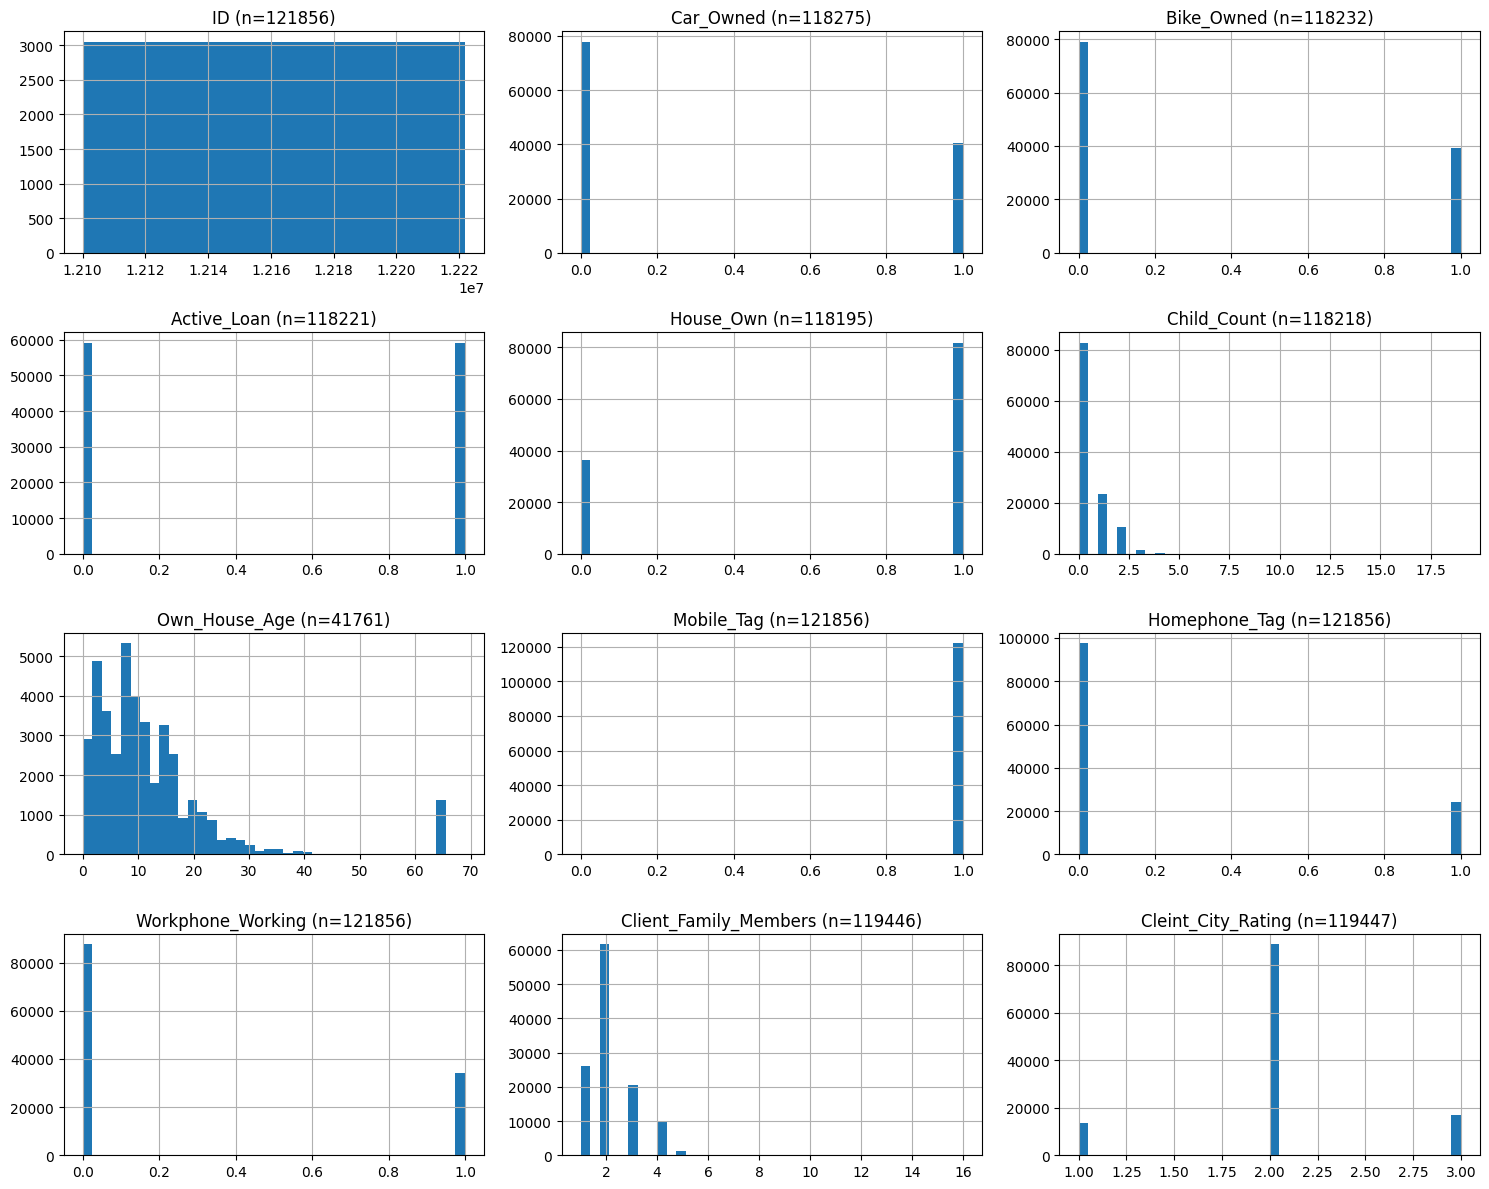

,col,outlier_count,lower,upper
11,Cleint_City_Rating,30498,2.000000,2.000000
8,Homephone_Tag,24432,0.000000,0.000000
19,Default,9845,0.000000,0.000000
16,Social_Circle_Default,4153,-0.078500,0.284700
6,Own_House_Age,2064,-10.000000,30.000000
5,Child_Count,1659,-1.500000,2.500000
10,Client_Family_Members,1564,0.500000,4.500000
18,Credit_Bureau,1303,-4.500000,7.500000
13,Application_Process_Hour,917,4.000000,20.000000
17,Phone_Change,181,-1675.000000,3517.000000


,col,n_unique,top_3,top_count
11,Age_Days,22583,"[nan, 10065, 16987]",3600
13,Registration_Days,19254,"[nan, 1, 9]",3614
2,Loan_Annuity,16680,"[nan, 900, 1350]",4812
12,Employed_Days,13220,"[365243, nan, 365243.0]",19848
14,ID_Days,9655,"[nan, 4053, 4375]",5968
1,Credit_Amount,6816,"[nan, 45000.0, 67500.0]",3632
0,Client_Income,1516,"[13500, 11250, 15750]",11908
19,Score_Source_3,1430,"[nan, 0.746300213, 0.694092643]",26921
10,Population_Region_Relative,164,"[nan, 0.035792, 0.04622]",4857
18,Type_Organization,58,"[Business Entity Type 3, XNA, Self-employed]",26279



Default rate by Client_Income


,count,default_rate
Client_Income,,
13500,11908,0.088848
11250,10302,0.089691
15750,8719,0.091524
18000,8215,0.083384
9000,7577,0.079319
22500,6927,0.073192
20250,5460,0.083516
27000,3624,0.063742



Default rate by Credit_Amount


,count,default_rate
Credit_Amount,,
45000.0,2513,0.120573
67500.0,2340,0.079915
22500.0,2090,0.071770
27000.0,1865,0.058981
18000.0,1847,0.075257
90000.0,1624,0.046182
45000,1220,0.110656
54504.0,1186,0.172850



Default rate by Loan_Annuity


,count,default_rate
Loan_Annuity,,
900,1885,0.082228
1350,1684,0.051069
675,682,0.067449
1012.5,622,0.065916
3780,504,0.067460
900.0,485,0.078351
2621.7,461,0.097614
1125,448,0.035714



Default rate by Accompany_Client


,count,default_rate
Accompany_Client,,
Alone,97409,0.082220
Relative,15748,0.074359
Partner,4516,0.079274
Kids,1334,0.067466
Others,987,0.086120
Group,104,0.067308



Default rate by Client_Income_Type


,count,default_rate
Client_Income_Type,,
Service,61028,0.094809
Commercial,27764,0.075890
Retired,21043,0.055410
Govt Job,8303,0.058292



Default rate by Client_Education


,count,default_rate
Client_Education,,
Secondary,83911,0.090918
Graduation,28819,0.050835
Graduation dropout,3960,0.082828
Junior secondary,1455,0.105155



Default rate by Client_Marital_Status


,count,default_rate
Client_Marital_Status,,
M,87349,0.079074
S,17404,0.096989
D,7556,0.077290
W,6074,0.064537



Default rate by Client_Gender


,count,default_rate
Client_Gender,,
Male,78463,0.070670
Female,40977,0.100154


AUC on test (quick): 0.7823658121677864


Score_Source_2                0.097853
Score_Source_3                0.088361
Age_Days                      0.054634
Credit_Amount                 0.053133
Phone_Change                  0.051305
Loan_Annuity                  0.051165
Registration_Days             0.050866
ID_Days                       0.050072
Employed_Days                 0.044570
Score_Source_1                0.044096
Population_Region_Relative    0.040947
Client_Income                 0.038713
Social_Circle_Default         0.032774
Application_Process_Hour      0.032277
Type_Organization             0.030207
dtype: float64

In [57]:
run_eda(df1,target="Default")

In [61]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from category_encoders.target_encoder import TargetEncoder
from scipy.stats import skew

# ----------------------------------------------------------------
# 1) Identify numeric & categorical columns
# ----------------------------------------------------------------
def get_columns(df, target="Default"):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

    # Remove target from lists
    if target in numeric_cols: numeric_cols.remove(target)
    if target in categorical_cols: categorical_cols.remove(target)

    return numeric_cols, categorical_cols

# ----------------------------------------------------------------
# 2) Drop high-missing columns
# ----------------------------------------------------------------
def drop_high_missing(df, threshold=0.60):
    missing_percent = df.isnull().mean()
    drop_cols = missing_percent[missing_percent > threshold].index.tolist()

    print("Dropping high-missing columns:", drop_cols)
    df = df.drop(columns=drop_cols)
    return df, drop_cols

# ----------------------------------------------------------------
# 3) Numeric Missing: Median Imputation
# ----------------------------------------------------------------
# def impute_numeric(df, numeric_cols):
#     imputer = SimpleImputer(strategy="median")
#     df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
#     return df, imputer
def impute_numeric(df, numeric_cols):
    if len(numeric_cols) == 0:
        return df, None

    imputer = SimpleImputer(strategy="median")
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    return df, imputer

# ----------------------------------------------------------------
# 4) Categorical Missing: Fill with Mode or Constant
# ----------------------------------------------------------------
def impute_categorical(df, categorical_cols, fill_value="Unknown"):
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0] if df[col].mode().size else fill_value)
    return df

# ----------------------------------------------------------------
# 5) Detect and treat outliers - Winsorization (IQR method)
# ----------------------------------------------------------------
def winsorize_series(s):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return np.clip(s, lower, upper)

# def winsorize_outliers(df, numeric_cols):
#     for col in numeric_cols:
#         df[col] = winsorize_series(df[col])
#     return df
def winsorize_outliers(df, numeric_cols):
    if len(numeric_cols) == 0:
        return df
    for col in numeric_cols:
        df[col] = winsorize_series(df[col])
    return df

# ----------------------------------------------------------------
# 6) Log-transform highly skewed features
# ----------------------------------------------------------------
# def log_transform(df, numeric_cols, threshold=1.0):
#     for col in numeric_cols:
#         if abs(skew(df[col])) > threshold and (df[col] > 0).all():
#             df[col] = np.log1p(df[col])
#             print("Log-transformed:", col)
#     return df

def log_transform(df, numeric_cols, threshold=1.0):
    if len(numeric_cols) == 0:
        return df

    for col in numeric_cols:
        if (df[col] > 0).all() and abs(skew(df[col])) > threshold:
            df[col] = np.log1p(df[col])
            print("Log-transformed:", col)
    return df


# ----------------------------------------------------------------
# 7) Encode Categorical Variables
# ----------------------------------------------------------------
# def encode_categoricals(df, categorical_cols, target, cardinality_threshold=10):
#     low_cardinality = [c for c in categorical_cols if df[c].nunique() <= cardinality_threshold]
#     high_cardinality = [c for c in categorical_cols if df[c].nunique() > cardinality_threshold]

#     print("Low-cardinality Label Encoded:", low_cardinality)
#     print("High-cardinality Target Encoded:", high_cardinality)

#     # Label Encoding
#     label_encoders = {}
#     for col in low_cardinality:
#         le = LabelEncoder()
#         df[col] = le.fit_transform(df[col])
#         label_encoders[col] = le

#     # Target Encoding for high-cardinality  
#     target_encoder = None
#     if high_cardinality:
#         target_encoder = TargetEncoder(cols=high_cardinality)
#         df[high_cardinality] = target_encoder.fit_transform(df[high_cardinality], df[target])

#     return df, label_encoders, target_encoder
def encode_categoricals(df, categorical_cols, target, cardinality_threshold=10):
    if len(categorical_cols) == 0:
        return df, {}, None

    low_cardinality = [c for c in categorical_cols if df[c].nunique() <= cardinality_threshold]
    high_cardinality = [c for c in categorical_cols if df[c].nunique() > cardinality_threshold]

    print("Low-cardinality Label Encoded:", low_cardinality)
    print("High-cardinality Target Encoded:", high_cardinality)

    label_encoders = {}

    # Label encoding for low-cardinality features
    for col in low_cardinality:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Target encoding only if there are columns
    target_encoder = None
    if len(high_cardinality) > 0:
        target_encoder = TargetEncoder(cols=high_cardinality)
        df[high_cardinality] = target_encoder.fit_transform(df[high_cardinality], df[target])

    return df, label_encoders, target_encoder




In [62]:
# ----------------------------------------------------------------
# 8) Full Preprocessing Pipeline
# ----------------------------------------------------------------
def preprocess_data(df, target="Default"):
    df = df.copy()

    print("\nSTARTING PREPROCESSING...\n")

    # 1. Identify columns
    numeric_cols, categorical_cols = get_columns(df, target)

    # 2. Drop high-missing columns
    df, dropped_cols = drop_high_missing(df)

    # Update column lists after drops
    numeric_cols, categorical_cols = get_columns(df, target)
    

    # 3. Handle missing values
    df, num_imputer = impute_numeric(df, numeric_cols)
    df = impute_categorical(df, categorical_cols)

    # 4. Outlier treatment
    df = winsorize_outliers(df, numeric_cols)

    # 5. Apply log transform to skewed features
    df = log_transform(df, numeric_cols)

    # 6. Encode categorical variables
    df, label_encoders, target_encoder = encode_categoricals(
        df, categorical_cols, target
    )

    print("\nPREPROCESSING COMPLETED!\n")

    return df, {
        "numeric_imputer": num_imputer,
        "label_encoders": label_encoders,
        "target_encoder": target_encoder,
        "dropped_columns": dropped_cols
    }

In [64]:
df_clean, preprocessors = preprocess_data(df1, target="Default")



STARTING PREPROCESSING...

Dropping high-missing columns: ['Own_House_Age']
Low-cardinality Label Encoded: ['Accompany_Client', 'Client_Income_Type', 'Client_Education', 'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type', 'Client_Housing_Type', 'Client_Permanent_Match_Tag', 'Client_Contact_Work_Tag']
High-cardinality Target Encoded: ['Client_Income', 'Credit_Amount', 'Loan_Annuity', 'Population_Region_Relative', 'Age_Days', 'Employed_Days', 'Registration_Days', 'ID_Days', 'Client_Occupation', 'Type_Organization', 'Score_Source_3']

PREPROCESSING COMPLETED!



In [70]:
df_clean, preprocessors = preprocess_data(df1, target="Default")


STARTING PREPROCESSING...

Dropping high-missing columns: ['Own_House_Age']
Low-cardinality Label Encoded: ['Accompany_Client', 'Client_Income_Type', 'Client_Education', 'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type', 'Client_Housing_Type', 'Client_Permanent_Match_Tag', 'Client_Contact_Work_Tag']
High-cardinality Target Encoded: ['Client_Income', 'Credit_Amount', 'Loan_Annuity', 'Population_Region_Relative', 'Age_Days', 'Employed_Days', 'Registration_Days', 'ID_Days', 'Client_Occupation', 'Type_Organization', 'Score_Source_3']

PREPROCESSING COMPLETED!

Remaining missing values: 0


In [71]:
df_clean.isnull().sum()

ID                            0
Client_Income                 0
Car_Owned                     0
Bike_Owned                    0
Active_Loan                   0
House_Own                     0
Child_Count                   0
Credit_Amount                 0
Loan_Annuity                  0
Accompany_Client              0
Client_Income_Type            0
Client_Education              0
Client_Marital_Status         0
Client_Gender                 0
Loan_Contract_Type            0
Client_Housing_Type           0
Population_Region_Relative    0
Age_Days                      0
Employed_Days                 0
Registration_Days             0
ID_Days                       0
Mobile_Tag                    0
Homephone_Tag                 0
Workphone_Working             0
Client_Occupation             0
Client_Family_Members         0
Cleint_City_Rating            0
Application_Process_Day       0
Application_Process_Hour      0
Client_Permanent_Match_Tag    0
Client_Contact_Work_Tag       0
Type_Org

In [66]:
def preprocess_data(df, target="Default"):
    df = df.copy()

    print("\nSTARTING PREPROCESSING...\n")

    # ----------------------------------------------------------------
    # 1. Identify columns initially
    # ----------------------------------------------------------------
    numeric_cols, categorical_cols = get_columns(df, target)

    # ----------------------------------------------------------------
    # 2. Drop high-missing columns
    # ----------------------------------------------------------------
    df, dropped_cols = drop_high_missing(df)
    
    # Recompute column groups again
    numeric_cols, categorical_cols = get_columns(df, target)

    # ----------------------------------------------------------------
    # 3. Numeric Missing Imputation
    # ----------------------------------------------------------------
    if len(numeric_cols) > 0:
        df, num_imputer = impute_numeric(df, numeric_cols)
    else:
        num_imputer = None

    # ----------------------------------------------------------------
    # 4. Categorical Missing Imputation
    # ----------------------------------------------------------------
    if len(categorical_cols) > 0:
        df = impute_categorical(df, categorical_cols)

    # ----------------------------------------------------------------
    # 5. Outlier Treatment
    # ----------------------------------------------------------------
    if len(numeric_cols) > 0:
        df = winsorize_outliers(df, numeric_cols)

    # ----------------------------------------------------------------
    # 6. Log Transform
    # ----------------------------------------------------------------
    if len(numeric_cols) > 0:
        df = log_transform(df, numeric_cols)

    # ----------------------------------------------------------------
    # 7. Encoding Categorical Features
    # ----------------------------------------------------------------
    df, label_encoders, target_encoder = encode_categoricals(
        df,
        categorical_cols,
        target
    )

    # ----------------------------------------------------------------
    # 8. FINAL STEP — Fix unhandled missing values
    #    Sometimes transformations OR target encoding reintroduce NaNs.
    # ----------------------------------------------------------------
    if df.isnull().sum().sum() > 0:
        print("\nFixing remaining missing values...\n")
        df = df.fillna({
            **{col: df[col].median() for col in df.select_dtypes(include=[np.number]).columns},
            **{col: df[col].mode()[0] for col in df.select_dtypes(include=["object"]).columns}
        })

    print("\nPREPROCESSING COMPLETED!\n")
    print("Remaining missing values:", df.isnull().sum().sum())

    return df, {
        "numeric_imputer": num_imputer,
        "label_encoders": label_encoders,
        "target_encoder": target_encoder,
        "dropped_columns": dropped_cols
    }


In [67]:
df_clean, preprocessors = preprocess_data(df1, target="Default")


STARTING PREPROCESSING...

Dropping high-missing columns: ['Own_House_Age']
Low-cardinality Label Encoded: ['Accompany_Client', 'Client_Income_Type', 'Client_Education', 'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type', 'Client_Housing_Type', 'Client_Permanent_Match_Tag', 'Client_Contact_Work_Tag']
High-cardinality Target Encoded: ['Client_Income', 'Credit_Amount', 'Loan_Annuity', 'Population_Region_Relative', 'Age_Days', 'Employed_Days', 'Registration_Days', 'ID_Days', 'Client_Occupation', 'Type_Organization', 'Score_Source_3']

PREPROCESSING COMPLETED!

Remaining missing values: 0


In [69]:
df_clean.isnull().sum()

ID                            0
Client_Income                 0
Car_Owned                     0
Bike_Owned                    0
Active_Loan                   0
House_Own                     0
Child_Count                   0
Credit_Amount                 0
Loan_Annuity                  0
Accompany_Client              0
Client_Income_Type            0
Client_Education              0
Client_Marital_Status         0
Client_Gender                 0
Loan_Contract_Type            0
Client_Housing_Type           0
Population_Region_Relative    0
Age_Days                      0
Employed_Days                 0
Registration_Days             0
ID_Days                       0
Mobile_Tag                    0
Homephone_Tag                 0
Workphone_Working             0
Client_Occupation             0
Client_Family_Members         0
Cleint_City_Rating            0
Application_Process_Day       0
Application_Process_Hour      0
Client_Permanent_Match_Tag    0
Client_Contact_Work_Tag       0
Type_Org

In [72]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.base import BaseEstimator, TransformerMixin

# # ---------------------------
# # Custom Outlier Handler (Winsorizer)
# # ---------------------------
# class Winsorizer(BaseEstimator, TransformerMixin):
#     def __init__(self, lower=0.01, upper=0.99):
#         self.lower = lower
#         self.upper = upper

#     def fit(self, X, y=None):
#         self.lower_bounds_ = np.percentile(X, self.lower * 100, axis=0)
#         self.upper_bounds_ = np.percentile(X, self.upper * 100, axis=0)
#         return self

#     def transform(self, X):
#         X_clipped = np.clip(X, self.lower_bounds_, self.upper_bounds_)
#         return X_clipped


# # ---------------------------
# # Load Your Dataset
# # ---------------------------
# df = pd.read_csv("D:\Data Science case study\-Loan-Default-Prediction-and-Evaluation-Criteria\RAW_DATA\DATA\data-selected\Data_Dictionary.csv")

# # Replace this with your target
# target = "Default"

# X = df.drop(columns=[target],axis=1)
# y = df[target]

# # ---------------------------
# # Identify numeric & categorical
# # ---------------------------
# numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
# categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# # ---------------------------
# # Drop highly missing columns (>60%)
# # ---------------------------
# threshold = 0.6
# missing_ratio = X.isnull().mean()

# cols_to_drop = missing_ratio[missing_ratio > threshold].index.tolist()
# X = X.drop(columns=cols_to_drop)

# numeric_features = [col for col in numeric_features if col not in cols_to_drop]
# categorical_features = [col for col in categorical_features if col not in cols_to_drop]

# # ---------------------------
# # Split Data
# # ---------------------------
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# # ---------------------------
# # Preprocessing Pipelines
# # ---------------------------

# # ✔ Numeric: Missing → Winsorizer → Log → Scaling
# numeric_pipeline = Pipeline(steps=[
#     ("imputer", SimpleImputer(strategy="median")),
#     ("winsor", Winsorizer(lower=0.01, upper=0.99)),
#     ("log", FunctionTransformer(lambda x: np.log1p(x))),  # safe log
#     ("scaler", StandardScaler())
# ])

# # ✔ Categorical: Missing → Mode → One-hot
# categorical_pipeline = Pipeline(steps=[
#     ("imputer", SimpleImputer(strategy="most_frequent")),
#     ("encoder", OneHotEncoder(handle_unknown="ignore"))
# ])

# # ---------------------------
# # Combine Pipelines
# # ---------------------------
# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", numeric_pipeline, numeric_features),
#         ("cat", categorical_pipeline, categorical_features)
#     ]
# )

# # ---------------------------
# # Final Pipeline Example (with LightGBM / RandomForest etc.)
# # ---------------------------
# from sklearn.ensemble import RandomForestClassifier

# model_pipeline = Pipeline(steps=[
#     ("preprocess", preprocessor),
#     ("model", RandomForestClassifier())
# ])

# # ---------------------------
# # Train
# # ---------------------------
# model_pipeline.fit(X_train, y_train)

# # ---------------------------
# # Predict
# # ---------------------------
# preds = model_pipeline.predict(X_test)
# print("Predictions :", preds[:10])


In [73]:
from sklearn.model_selection import train_test_split

X = df_clean.drop(columns=["Default"])
y = df_clean["Default"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)


In [74]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight="balanced",   # handle imbalance
    n_jobs=-1
)

model.fit(X_train, y_train)


,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [75]:
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    confusion_matrix,
    classification_report
)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9618824881010997
ROC-AUC: 0.9838562985390639

Confusion Matrix:
 [[22211   192]
 [  737  1232]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     22403
           1       0.87      0.63      0.73      1969

    accuracy                           0.96     24372
   macro avg       0.92      0.81      0.85     24372
weighted avg       0.96      0.96      0.96     24372



In [79]:
#As per recall and precision result on class-1,looks like data is imbalanced...

In [81]:
pip install lightgbm


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 19.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [82]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=-1,
    random_state=42,
    class_weight="balanced"
)

lgb_model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 7876, number of negative: 89608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2846
[LightGBM] [Info] Number of data points in the train set: 97484, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.03
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [84]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [85]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)


In [86]:
y_prob = model.predict_proba(X_test)[:, 1]

# Set new threshold
threshold = 0.35
y_pred_new = (y_prob > threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_new))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98     22403
           1       0.79      0.77      0.78      1969

    accuracy                           0.96     24372
   macro avg       0.88      0.88      0.88     24372
weighted avg       0.96      0.96      0.96     24372



In [87]:
#as per above result,still looks-like data imbalance is there

In [89]:
#pip install xgboost



   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   - -------------------------------------- 3.4/72.0 MB 33.8 MB/s eta 0:00:03
   -- ------------------------------------- 4.2/72.0 MB 10.5 MB/s eta 0:00:07
   --- ------------------------------------ 5.8/72.0 MB 9.8 MB/s eta 0:00:07
   --- ------------------------------------ 6.6/72.0 MB 8.1 MB/s eta 0:00:09
   ---- ----------------------------------- 7.3/72.0 MB 7.2 MB/s eta 0:00:09
   ---- ----------------------------------- 8.1/72.0 MB 6.5 MB/s eta 0:00:10
   ---- ----------------------------------- 8.9/72.0 MB 6.2 MB/s eta 0:00:11
   ----- ---------------------------------- 10.0/72.0 MB 6.1 MB/s eta 0:00:11
   ------ --------------------------------- 11.3/72.0 MB 6.0 MB/s eta 0:00:11
   ------ --------------------------------- 12.3/72.0 MB 6.0 MB/s eta 0:00:10
   ------- -------------------------------- 13.1/72.0 MB 5.8 MB/s eta 0:00:11
   ------- -------------------------------- 13.9/72.0 MB 5.6 MB/s eta 0:00:1

In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# ----------------------------------------
# 1. Prepare Data
# ----------------------------------------
X = df_clean.drop('Default', axis=1)
y = df_clean['Default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ----------------------------------------
# 2. Handle Class Imbalance
# scale_pos_weight = (number of negative samples) / (positive samples)
# ----------------------------------------
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale = neg / pos

print("scale_pos_weight =", scale)

# ----------------------------------------
# 3. Train XGBoost
# ----------------------------------------
# model = XGBClassifier(
#     n_estimators=300,
#     learning_rate=0.05,
#     max_depth=6,
#     subsample=0.9,
#     colsample_bytree=0.8,
#     eval_metric='logloss',
#     scale_pos_weight=scale  # important for imbalance
# )
model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=7,
    gamma=0.1,
    subsample=0.9,
    colsample_bytree=0.8,
    min_child_weight=3,
    reg_alpha=0.5,
    reg_lambda=1.0,
    scale_pos_weight=scale,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# ----------------------------------------
# 4. Predict using default threshold (0.5)
# ----------------------------------------
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


scale_pos_weight = 11.377348908075165
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     22403
           1       0.63      0.92      0.75      1969

    accuracy                           0.95     24372
   macro avg       0.81      0.94      0.86     24372
weighted avg       0.96      0.95      0.95     24372



In [97]:
# Predict probabilities
#Version With Probability Threshold Tuning (Boost recall for class 1)
y_prob = model.predict_proba(X_test)[:, 1]

# Lower threshold = higher recall for class 1
threshold = 0.35  # you can tune this (0.2–0.5)
y_pred = (y_prob > threshold).astype(int)

print("Using threshold:", threshold)
print(classification_report(y_test, y_pred))


Using threshold: 0.35
              precision    recall  f1-score   support

           0       1.00      0.94      0.96     22403
           1       0.56      0.95      0.71      1969

    accuracy                           0.94     24372
   macro avg       0.78      0.94      0.84     24372
weighted avg       0.96      0.94      0.94     24372



In [98]:
#precision value lagging while recall increase,trying below with more hyper-parameter tunning


In [99]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# ----------------------------------------------------
# 1. Train-Test Split
# ----------------------------------------------------

X = df_clean.drop('Default', axis=1)
y = df_clean['Default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ----------------------------------------------------
# 2. Handle Imbalance
# ----------------------------------------------------
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale = neg / pos
print("scale_pos_weight =", scale)

# ----------------------------------------------------
# 3. Model Base
# ----------------------------------------------------
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale,  # IMPORTANT for imbalance
    use_label_encoder=False
)

# ----------------------------------------------------
# 4. Parameter Search Space
# ----------------------------------------------------
param_dist = {
    "n_estimators": [200, 300, 400, 500, 600],
    "learning_rate": [0.01, 0.03, 0.05, 0.07, 0.1],
    "max_depth": [3, 4, 5, 6, 7, 8],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9],
    "gamma": [0, 0.1, 0.2, 0.3, 0.5],
    "min_child_weight": [1, 2, 3, 4, 5],
    "reg_alpha": [0, 0.1, 0.3, 0.5, 1],
    "reg_lambda": [0.5, 1, 2, 3]
}

# ----------------------------------------------------
# 5. Randomized Search
# ----------------------------------------------------
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=40,              # number of combinations
    scoring="f1",           # optimize for minority class
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# ----------------------------------------------------
# 6. Best Model
# ----------------------------------------------------
print("Best Params:", random_search.best_params_)
best_model = random_search.best_estimator_

# ----------------------------------------------------
# 7. Predict & Final Evaluation
# ----------------------------------------------------
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


scale_pos_weight = 11.377348908075165
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 600, 'min_child_weight': 4, 'max_depth': 7, 'learning_rate': 0.07, 'gamma': 0.1, 'colsample_bytree': 0.5}
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     22403
           1       0.70      0.89      0.78      1969

    accuracy                           0.96     24372
   macro avg       0.85      0.93      0.88     24372
weighted avg       0.97      0.96      0.96     24372



In [100]:
y_prob = best_model.predict_proba(X_test)[:, 1]

for t in [0.20, 0.25, 0.30, 0.35, 0.40]:
    y_pred = (y_prob > t).astype(int)
    print("Threshold:", t)
    print(classification_report(y_test, y_pred))


Threshold: 0.2
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     22403
           1       0.59      0.95      0.73      1969

    accuracy                           0.94     24372
   macro avg       0.79      0.94      0.85     24372
weighted avg       0.96      0.94      0.95     24372

Threshold: 0.25
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     22403
           1       0.61      0.94      0.74      1969

    accuracy                           0.95     24372
   macro avg       0.80      0.94      0.86     24372
weighted avg       0.96      0.95      0.95     24372

Threshold: 0.3
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     22403
           1       0.63      0.93      0.75      1969

    accuracy                           0.95     24372
   macro avg       0.81      0.94      0.86     24372
weighted avg       0.96     

In [102]:
#After changing threshold value,we can get best result as per requieremnt of precision, recall and f1-score